# Diagnostic explorations with gsum

This notebook provides hands-on examples of what can be learned from Gaussian process (GP) model-checking diagnostics.  The authoritative reference is Bastos and O'Hagan, [*Diagnostics for Gaussian process emulators*](https://www2.stat.duke.edu/courses/Spring14/sta961.01/ref/BastOHag2009.pdf).


## Overview 

We cover the following questions (with summary answers):
   1. How quickly do the empirical distributions of the Mahalanobis distance (MD) approach the theoretical distributions? We find that the GP case converges more quickly than the TP case.
   1. How do particular misspecifications of the GP assumptions show up in the MD and pivoted Cholesky (PC) diagnostics? We find that
       * an overestimated length scale (with correctly identified marginal variance) leads to good PC at small index, and large PC at high index;
       * an underestimated length scale (with correctly identified marginal variance) leads to good PC at small index, and small PC at high index;
       * an overestimated marginal variance (with correctly identified length scale) leads to small PC at all indices;
       * an underestimated marginal variance (with correctly identified length scale) leads to large PC at all indices.
   1. Concerning the credible interval diagnostic:
       * Is it robust against scaling factors? Yes.
       * Can the empirical distribution be approximated by a binomial distribution with an effective sample size? Yes.

### Summary table

$\sigma_{\textrm{est}}$ | $\ell_{\textrm{est}}$ | Appearance of PC diagnostic
:---: | :---: | :---
$\sigma_{\textrm{est}} = \sigma_{\textrm{true}}$ | $\ell_{\textrm{est}} = \ell_{\textrm{true}}$ | Points are distributed with no preference for small or high index and with expected 2$\sigma$ frequency (e.g., only $\approx$5% of points outside 2$\sigma$ lines).
$\sigma_{\textrm{est}} = \sigma_{\textrm{true}}$ | $\ell_{\textrm{est}} > \ell_{\textrm{true}}$ | Points look well distributed at small index but grow to overly large PC values at high index.
$\sigma_{\textrm{est}} = \sigma_{\textrm{true}}$ | $\ell_{\textrm{est}} < \ell_{\textrm{true}}$ | Points look well distributed at small index but shrink to a too-small range at high index.
$\sigma_{\textrm{est}} > \sigma_{\textrm{true}}$ | $\ell_{\textrm{est}} = \ell_{\textrm{true}}$ | Points are distributed in a too-small range at all indices.
$\sigma_{\textrm{est}} < \sigma_{\textrm{true}}$ | $\ell_{\textrm{est}} = \ell_{\textrm{true}}$ | Points are distributed in a too-large range at all indices.

### Gaussian process (GP) kernels used here

We use [scikit learn](https://scikit-learn.org/stable/index.html) as a source of GP kernels. 
An alternative would be to use [GPy](https://sheffieldml.github.io/GPy/).


* [RBF](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html)
  * Radial-basis function kernel (aka squared-exponential kernel).
  * length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)

* [WhiteKernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html)
  * Used to add noise as independently and identically normally distributed.  The noise level is the *variance* of the noise.

* [Matern](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html)
  * "The class of Matern kernels is a generalization of the RBF and the absolute exponential kernel parameterized by an additional parameter nu."
  * length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5

* [ConstantKernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html)
  * "Can be used as part of a product-kernel where it scales the magnitude of the other factor (kernel) or as part of a sum-kernel, where it modifies the mean of the Gaussian process."

## Import modules and set formatting parameters

In [1]:
%load_ext autoreload
%autoreload 2
# Do we really need autoreload if we don't plan to touch the gsum code?
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

import numpy as np
import scipy.stats as stats

# Use scikit learn as source for Gaussian process kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.gaussian_process.kernels import ConstantKernel as C

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook  # For box-and-whisker plots

import gsum as gm    # This is the only local module used here

In [2]:
mpl.rcParams['figure.dpi'] = 120    # to make figures nicer

## Mahalanobis Distance (MD)

Let's look at the reference distribution for the (squared) Mahalanobis distance $D_{MD}^2$.
Assume that we are computing $D_{MD}^2$ using $m$ validation points.
Bastos & O'Hagan state that for the Gaussian case (GP), $D_{MD}^2$ should be distributed as a standard chi-squared with $m$ degrees of freedom:
\begin{align}
    D_{MD}^2 \sim \chi^2_m \;.
\end{align}
Note that this **does not** depend on the details of the mean or covariance matrix, only on the number of datapoints $m$.

Similarly, for a Student-$t$ process (TP) with $\nu$ degrees of freedom, the $D_{MD}^2$ should follow a (scaled) $F$-distribution $F(m,\nu)$ with a scale $\sigma = (\nu-2)m/\nu$.
By this we mean that $D_{MD}^2 / \sigma$ follows a standard $F(m,\nu)$ distribution.
Both the $\chi^2$ and the (scaled) $F$ distribution are available in Scipy and can be tested against distributions created from toy data.

Set up for our tests:

In [3]:
m = 20             # no. of validation points 
n_samples = 10000   # no. of samples to be drawn from the process
ls = 0.05           # length scale of the GP or TP
noise = 1e-6        # noise to add to kernel for numerical stability (?)
df = 4              # degrees of freedom (df) for TP. Must be greater than 2

kernel = RBF(ls) + WhiteKernel(noise)  # instantiate kernel object (sklearn)
X = np.linspace(0, 1, m)[:, None]      # evenly spaced 0 to 1. X is m by 1
mean = np.zeros(m)                     # mean function is taken to be zero
cov = kernel(X)    # Covariance matrix evaluated at X, so an m by m matrix
md_vals = np.linspace(0, 3*m, 100)     # range of values of MD for plots 

Using the above variables, test the GP case:

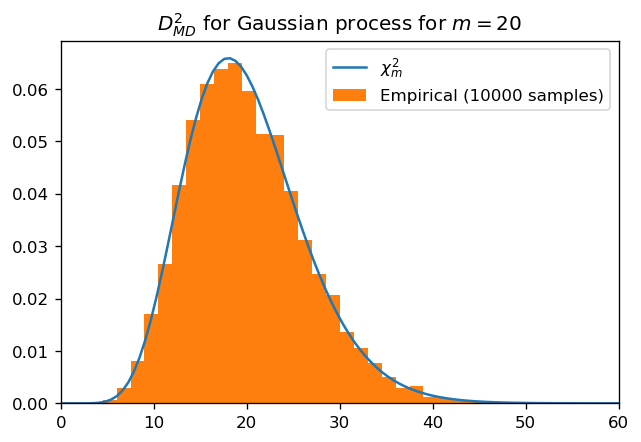

In [4]:
# gm.Diagnostic is a class for quickly testing the model checking methods 
#  discussed in Bastos & O'Hagan.
# With no df given, the diagnostics assume a GP

# Instantiate a GP diagnostic object with specified mean and covariance
#  random_state=None so different every time
diagnostic_gp = gm.Diagnostic(mean, cov, random_state=None)  
samples_gp = diagnostic_gp.samples(n_samples)  # generate samples  
md_samples_gp = diagnostic_gp.md_squared(samples_gp) # D_MD^2 for samples

# Generate the \chi^2 distribution from scipy.stats with dofs = m (see above)
chi2_dist = stats.chi2(df=m, scale=1) 

# Make a plot to compare the histogram of the Mahalanobis distance for a large
#  number of samples to the chi^2 distribution it is supposed to approach.
plt.plot(md_vals, chi2_dist.pdf(md_vals), label=r'$\chi^2_m$')
plt.hist(md_samples_gp, density=True, bins=40, align='mid',
         range=(md_vals.min(), md_vals.max()), 
         label=f'Empirical ({n_samples} samples)')
plt.title(rf'$D_{{MD}}^2$ for Gaussian process for $m = {m}$')
plt.legend()
plt.xlim(md_vals.min(), md_vals.max());

We see that the histogrammed empirical distribution does reproduce the claimed $\chi^2$ distribution. (Try `n_samples = 50000` and `bins = 80` and you'll see *really* good agreement. Also try different `m` values.) 

Now the TP case:

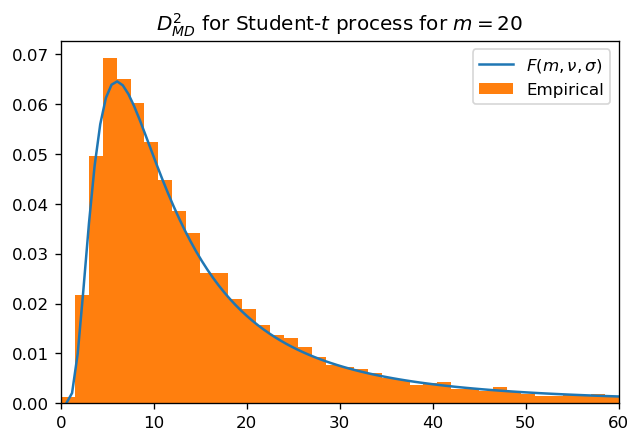

In [5]:
# With integer df, the diagnostics assume TP.
# instantiate a TP diagnostic object; random_state=None so different every time
diagnostic_tp = gm.Diagnostic(mean, cov, df=df, random_state=None) 
samples_tp = diagnostic_tp.samples(n_samples)  # generate samples  
md_samples_tp = diagnostic_tp.md_squared(samples_tp) # D_MD^2 for samples

# Generate the f distribution from scipy.stats with 𝜎=(𝜈−2)𝑚/𝜈 (see above).
f_dist = stats.f(dfn=m, dfd=df, scale=(df-2)*m/df)  

# Make a plot to compare the histogram of the Mahalanobis distance for a large
#  number of samples to the chi^2 distribution it is supposed to approach.
plt.plot(md_vals[1:], f_dist.pdf(md_vals[1:]), label=r'$F(m,\nu,\sigma)$')
plt.hist(md_samples_tp, density=True, bins=40, align='mid', 
         range=(md_vals.min(), md_vals.max()), label='Empirical')
plt.title(rf'$D_{{MD}}^2$ for Student-$t$ process for $m = {m}$')
plt.legend()
plt.xlim(md_vals.min(), md_vals.max());

So we see the expected $F$ distribution. (Try `n_samples = 50000` and `bins = 80` and you'll see *really* good agreement.  You can also try changing `m` and `df`.) 

Let's try a different representation to make the comparisons: boxplots (also known as "box-and-whisker" plots).

In [6]:
def dist_boxplot(dist, q1=0.25, q3=0.75, whislo=0.025, whishi=0.975, 
                 label=None, ax=None, other_stats=None, **kwargs):
    """Creates a boxplot computed from a scipy.stats-like distribution.
       The box extends from the lower to upper quartile values of the data, 
       with a line at the median. The whiskers extend from the box to show 
       (by default) the 95% limits of the data.
       
       When other_stats is specified, two boxplots (also "box-and-whisker
       plots") are drawn for comparison.
    """
    if ax is None:
        ax = plt.gca()
        
    stat_dict = [{'med': dist.median(), 'q1': dist.ppf(q1), 'q3': dist.ppf(q3),
                  'whislo': dist.ppf(whislo), 'whishi': dist.ppf(whishi)}]
    if label is not None:
        stat_dict[0]['label'] = label
    if other_stats is not None:
        stat_dict = [*stat_dict, *other_stats]
    ax.bxp(stat_dict, showfliers=False, **kwargs)  # draw box plots
    return ax

First the GP:

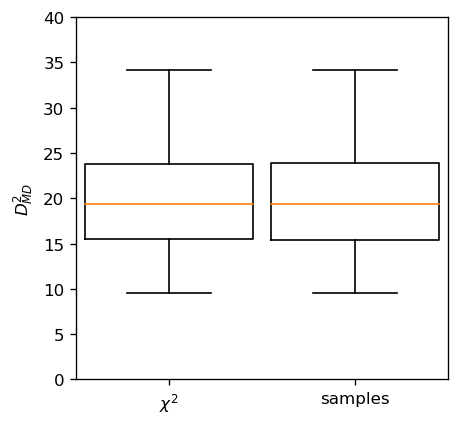

In [7]:
# Make box-and-whiskers plots to compare the chi^2 distribution to the 
#  samples from the GP.
fig, ax = plt.subplots(figsize=(4,4))
stat_dict_gp = cbook.boxplot_stats(md_samples_gp, whis=[2.5, 97.5], 
                                   labels=['samples'], bootstrap=None)
ax = dist_boxplot(chi2_dist, label=r'$\chi^2$', other_stats=stat_dict_gp, 
                  widths=0.9)
ax.set_ylim(0, 40)
ax.set_ylabel(r'$D_{MD}^2$');

Not bad agreement. Now look at the Student $t$ version.

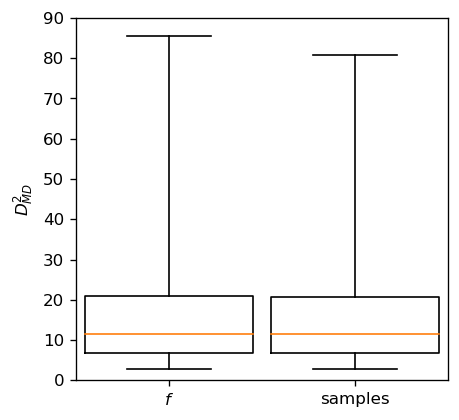

In [8]:
# Make box-and-whiskers plots to compare the chi^2 distribution to the 
#  samples from the GP.
fig, ax = plt.subplots(figsize=(4,4))
stat_dict_tp = cbook.boxplot_stats(md_samples_tp, whis=[2.5, 97.5], 
                                   labels=['samples'], bootstrap=None)
ax = dist_boxplot(f_dist, label=r'$f$', other_stats=stat_dict_tp, widths=0.9)
ax.set_ylim(0, 90)
ax.set_ylabel(r'$D_{MD}^2$');

As we see above, even with 10000 samples (!), the $2\sigma$ bands computed for the TP reference distribution by sampling are not as accurate compared to the true reference distribution as the GP case (but not so bad either, and the quality fluctuates). This is because the tails are quite long, so achieving this accuracy can take a lot of data.  If you change the number to 50000 samples, the plots will be essentially indistinguishable.

If we repeat everything for $m=5$ or $m=10$, the conclusions are the same; the graphs are just more skewed (longer high-end tail).

## Variance Decompositions

Here we demonstrate how to interpret Pivoted Cholesky plots.

For each example, we consider two cases: i) no specified intermediate points and ii) fitting to zeros at the integer values ("interp"). 

### Set up of parameters and plotting functions

In [9]:
n_decomp = 301          # plenty of points for smooth curves
n_simulated_curves = 6  # not too many curves so they are distinguishable
X_decomp = np.linspace(0, 3, n_decomp)[:, None]

# train every 100 points and validate on every 25, excluding training points
mask_train = np.array([i % 100 == 0 for i in range(n_decomp)])
mask_valid = np.array([i % 25 == 0 for i in range(n_decomp)]) & ~mask_train

true_mean = np.zeros(n_decomp)  # mean of zero
true_cov = kernel(X_decomp)     # true covariance for the specified points

ls = 0.8       # length scale
noise = 1e-5
kernel_PC = RBF(ls, length_scale_bounds='fixed') \
            + WhiteKernel(noise, noise_level_bounds='fixed')

gp_kwargs = dict(center=0, disp=0, df=np.inf, scale=1, optimizer=None, nugget=0)

In [10]:
def plot_decomposition_old(data_cov, est_mean, est_cov, X, n=6, seed=None, 
                           **kwargs):
    rng = np.random.RandomState(seed=seed)
    # samples = stats.multivariate_normal(true_mean, cov).rvs(n)
    samples = rng.multivariate_normal(est_mean, data_cov, size=n).T
    dgn = gm.Diagnostic(est_mean, est_cov, random_state=seed)
    eigen_samples = dgn.eigen_errors(samples)
    pc_samples = dgn.pivoted_cholesky_errors(samples)

    fig, axes = plt.subplots(1, 2, constrained_layout=True, **kwargs)
    axes[0].plot(X.ravel(), samples)
    axes[0].set_title('Curves')
    
    axes[1].plot(np.arange(1, len(true_mean)+1), pc_samples, ls='', marker='o')
    axes[1].axhline(2, 0, 1, ls='--', color='grey')
    axes[1].axhline(-2, 0, 1, ls='--', color='grey')
    axes[1].set_title('Pivoted Cholesky')
    return fig, axes


def plot_decomposition(data, kernel, X, mask=None, random_state=None, 
                       test_mask=None, interp=False, **kwargs):
    """
    Make a plot to show draws from a Gaussian process (GP) using kernel
    on the left and the correspoding Pivoted Cholesky (PC) plot on the right.
    
    To interpolate at the mask points, set interp=True.
    
    By default the draws are random (set random_state to an integer to get
    repeatable curves). 
    
    """
    
    # Instantiate a conjugacy-based GP with the passed sklearn kernel
    gp = gm.ConjugateGaussianProcess(kernel=kernel, random_state=random_state, 
                                     **kwargs)
    if interp:
        gp.fit(X[mask], data[mask])   # fit to the data at the masked points
        means, cov = gp.predict(X, return_cov=True)  # predict at the X points
        data = data - means        
        # get predictions at points where test_mask is True 
        if test_mask is None:
            test_mask = ~mask
        data_pred = data[test_mask]
        X_pred = X[test_mask]
        cov_pred = cov[test_mask][:, test_mask]
    else:
        # get predictions at points where test_mask is True 
        if test_mask is None:
            test_mask = slice(None)
        X_pred = X[test_mask]
        cov_pred = gp.cov(X_pred)
        data_pred = data[test_mask]
        
    # instantiate a diagnostic object    
    dgn = gm.Diagnostic(np.zeros(len(X_pred)), cov_pred, 
                        random_state=random_state)
    gr_dgn = gm.GraphicalDiagnostic(data_pred, np.zeros(len(X_pred)), cov_pred, 
                                    random_state=random_state)
    #eigen_samples = dgn.eigen_errors(data_pred)
    pc_samples = dgn.pivoted_cholesky_errors(data_pred)

    fig, axes = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)
    
    # plot the draws from the GP
    if mask is not None:
        axes[0].set_xticks(X[mask].ravel())  # set tick marks at the fit points
    axes[0].plot(X.ravel(), data)
    axes[0].set_xticks(X_pred.ravel(), minor=True) # validate at minor tick marks
    axes[0].set_title('Curves')
    axes[0].axhline(0, 0, 1, c='lightgrey', zorder=0)
    if interp:
        # plot open circles at the interpolation (fit) points
        axes[0].plot(X[mask].ravel(), np.zeros(sum(mask)), c='k', ls='', 
                     marker='o', fillstyle='none')
    
    # make the PC plot (indices from 1 to no. of prediction points)
    axes[1].plot(np.arange(1, len(X_pred)+1), pc_samples, ls='', marker='o')
    axes[1].axhline(2, 0, 1, ls='--', color='grey')
    axes[1].axhline(-2, 0, 1, ls='--', color='grey')
    axes[1].set_title('Pivoted Cholesky')
    axes[1].set_xlabel('index')
    
    gr_dgn.md_squared(ax=axes[2], type='box', trim=False, title=None)
    #axes[2].set_ylim(0, 40)
    
    return fig, axes

In [11]:
def draw_lengthscales(ls_true, ls_est=None, std=1, ax=None):
    """Draw double arrows to indicate the true and (if included) estimated
        lengths scales.
    """
    if ax is None:
        ax = plt.gca()
    # Draw length scale
    ax.annotate("", xy=(0.2, 1.5*std), xytext=(0.2+ls_true, 1.5*std),
                arrowprops=dict(arrowstyle="<->", capstyle='projecting', 
                                lw=1, color='k'), 
                annotation_clip=False)
    ax.text(0.2 + ls_true/2, 1.5*std, r'$\ell_{true}$', 
            horizontalalignment='center', verticalalignment='bottom')
    
    if ls_est is not None:
        ax.annotate("", xy=(0.2, 1.4*std), xytext=(0.2+ls_est, 1.4*std),
                    arrowprops=dict(arrowstyle="<->", capstyle='projecting', 
                                    lw=1, color='k'), 
                    annotation_clip=False)
        ax.text(0.2 + ls_est/2, 1.4*std, r'$\ell_{est}$', 
                horizontalalignment='center', verticalalignment='top')

def draw_std(std_true, std_est=None, ax=None):
    """Label the true and (if included) estimated standard deviation.    
    """
    if ax is None:
        ax = plt.gca()

    ax.set_yticks([-std_true, std_true])
    ax.set_yticklabels([r'$-\sigma_{true}$', r'$\sigma_{true}$'])
        
    if std_est is not None:
        if std_est < std_true:
            yticks = [-std_true, -std_est, std_est, std_true]
            yticklabels = [r'$-\sigma_{true}$', r'$-\sigma_{est}$', 
                           r'$\sigma_{est}$', r'$\sigma_{true}$']
        else:
            yticks = [-std_est, -std_true, std_true, std_est]
            yticklabels = [r'$-\sigma_{est}$', r'$-\sigma_{true}$', 
                           r'$\sigma_{true}$', r'$\sigma_{est}$']
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)

### Correct hyperparameters

The draws are from a GP with the same length scale and marginal variance as the reference GP.

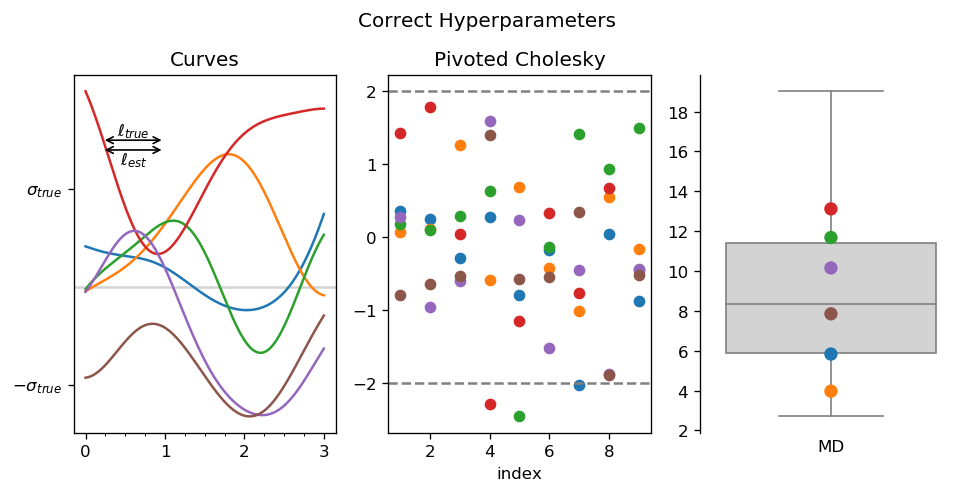

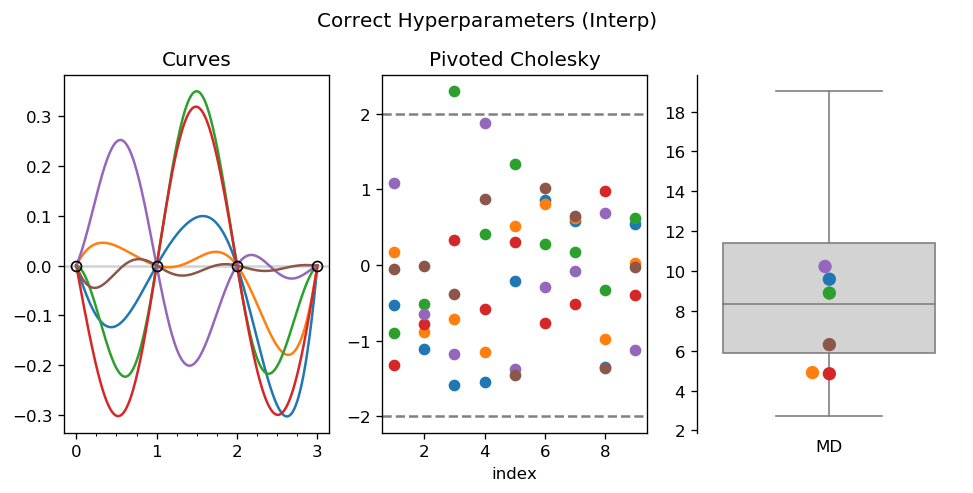

In [12]:
# Specify the correct kernel using sklearn kernels
kernel_correct = RBF(length_scale=ls, length_scale_bounds='fixed') + \
                 WhiteKernel(noise, noise_level_bounds='fixed')

# Instantiate the GP with the correct kernel
gp = gm.ConjugateGaussianProcess(kernel_correct, **gp_kwargs)

# Make n_simulated_curves draws from the correct kernel.  Suitable for plotting.
data = gp.sample_y(X_decomp, n_simulated_curves, random_state=None)

# Plot the curves and the associated PC points (no interpolation)
#  The minor ticks show the validation points.
fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=False, **gp_kwargs)
fig.suptitle('Correct Hyperparameters')
draw_std(1, ax=axes[0])
draw_lengthscales(ls, ls, ax=axes[0], std=1)

# Plot the interpolated curves and the associated PC points 
#  Interpolated points are zero at integer x values
fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=True, **gp_kwargs)

fig.suptitle('Correct Hyperparameters (Interp)');



Top plots show even distribution at all indices with 2$\sigma$ consistency.  Distribution for interpolated case shows less spread in the PC plot.

### Overestimate the length scale

The draws are from a GP with a smaller length scale but same marginal variance as the reference GP.  

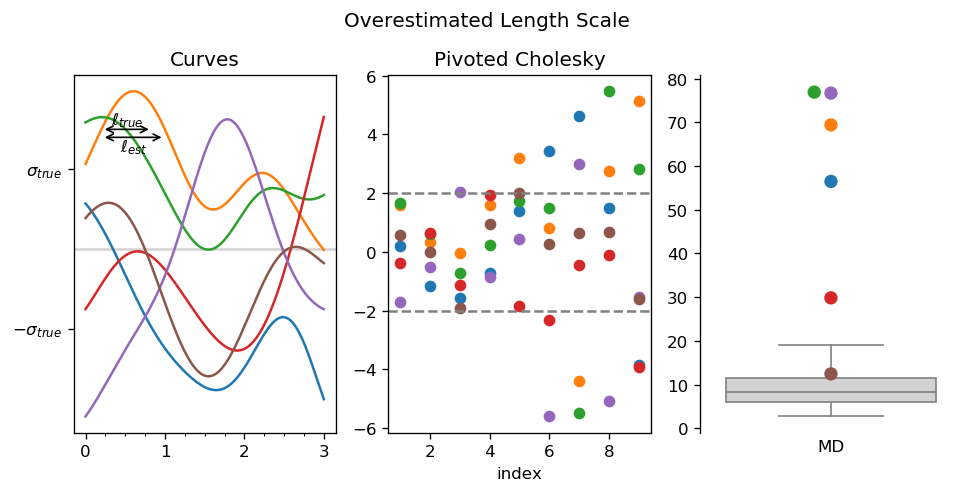

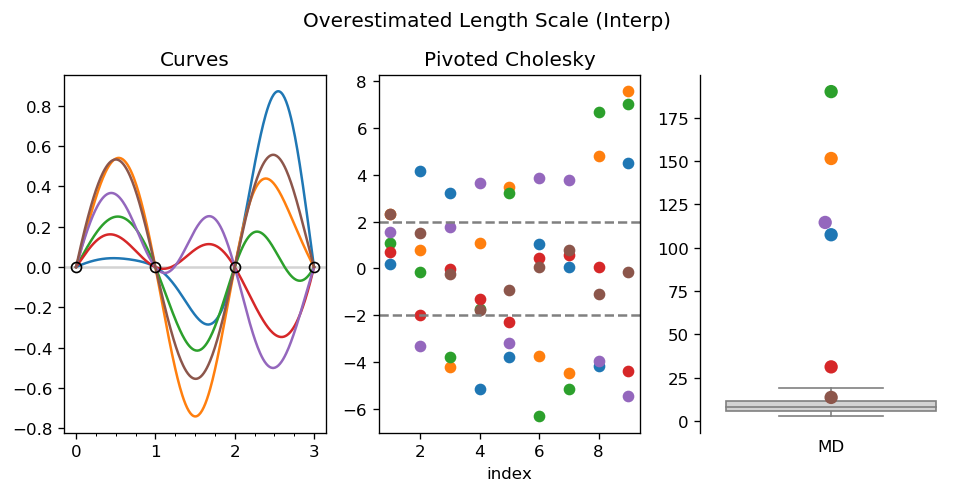

In [13]:
# Instantiate kernel with smaller length scale 
ls_small = 0.8 * ls  # this will be ls_true
kernel_small_ls = RBF(length_scale=ls_small, length_scale_bounds='fixed') \
                  + WhiteKernel(noise, noise_level_bounds='fixed')
# Instantiate GP with smaller length scale and draw curves
gp = gm.ConjugateGaussianProcess(kernel_small_ls, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves, random_state=1)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=False, **gp_kwargs)
fig.suptitle('Overestimated Length Scale')
draw_std(1, ax=axes[0])
draw_lengthscales(ls_small, ls, ax=axes[0], std=1)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=True, **gp_kwargs)
fig.suptitle('Overestimated Length Scale (Interp)');

Top plots show steady increase of PC values with increasing index.  Bottom plots show even more increase outside the dashed lines.

### Underestimate the length scale

The draws are from a GP with a larger length scale but same marginal variance as the reference GP.  

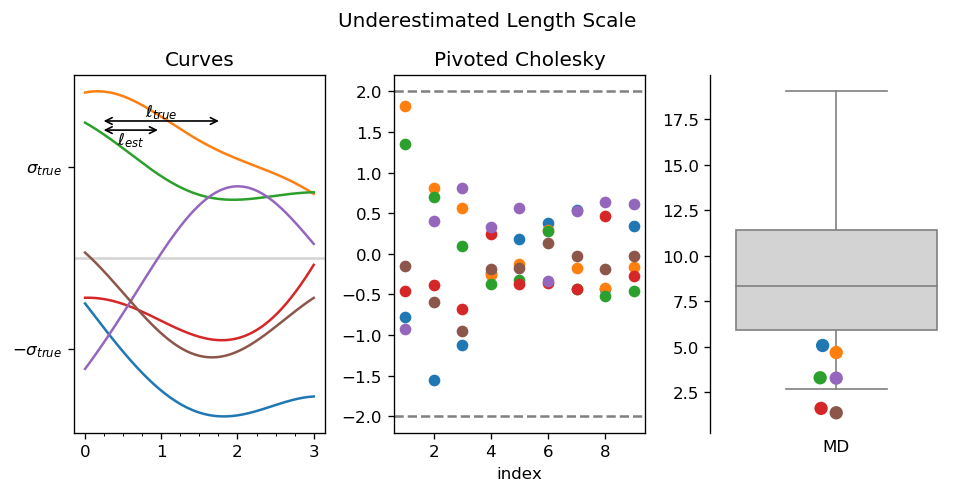

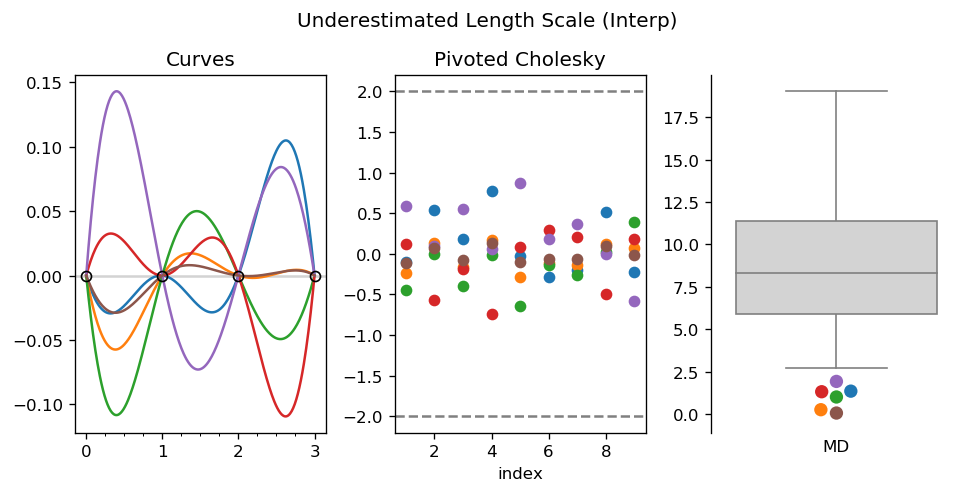

In [14]:
# Instantiate kernel with larger length scale 
ls_large = ls*2  # this will be ls_true
kernel_large_ls = RBF(length_scale=ls_large, length_scale_bounds='fixed') \
                  + WhiteKernel(noise, noise_level_bounds='fixed')
# Instantiate GP with larger length scale and draw curves
gp = gm.ConjugateGaussianProcess(kernel_large_ls, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves, random_state=1)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=False, **gp_kwargs)
fig.suptitle('Underestimated Length Scale')
draw_std(1, ax=axes[0])
draw_lengthscales(ls_large, ls, ax=axes[0], std=1)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=True, **gp_kwargs)
fig.suptitle('Underestimated Length Scale (Interp)');

### Underestimate the variance

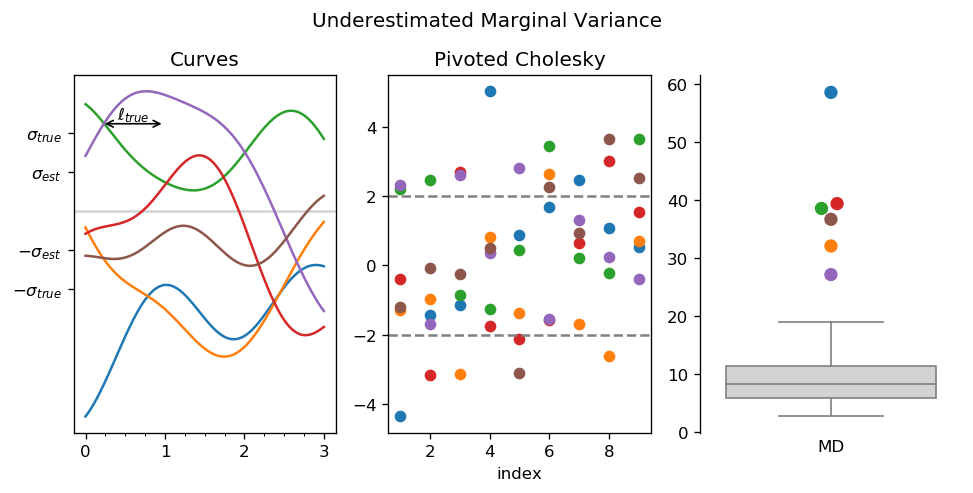

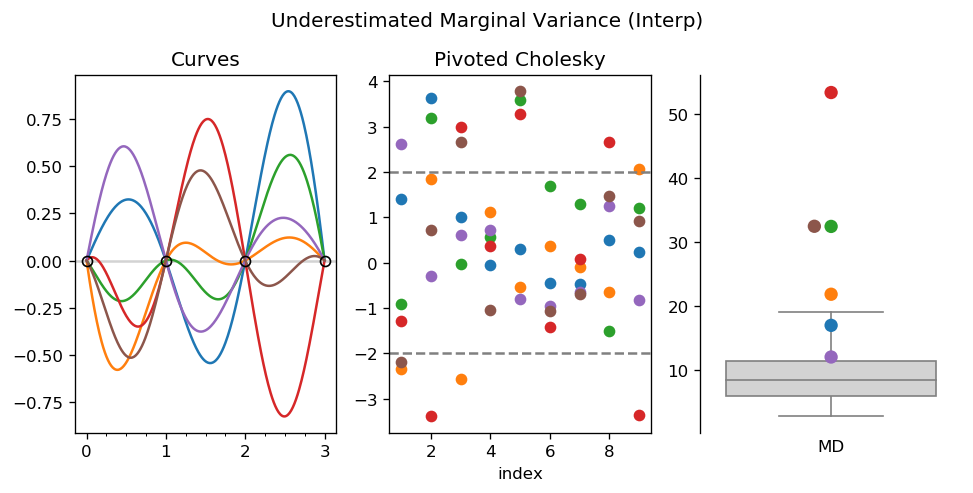

In [15]:
std_large = 2
kernel_large_sd = C(constant_value=std_large**2) * RBF(length_scale=ls) \
                  + WhiteKernel(noise)
gp = gm.ConjugateGaussianProcess(kernel_large_sd, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=False, **gp_kwargs)
fig.suptitle('Underestimated Marginal Variance')
draw_std(std_large, 1, ax=axes[0])
draw_lengthscales(ls, ax=axes[0], std=1.5)
# axes[0].set_ylim(-1.5, 1.5)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=True, **gp_kwargs)
fig.suptitle('Underestimated Marginal Variance (Interp)');

### Overestimate the variance

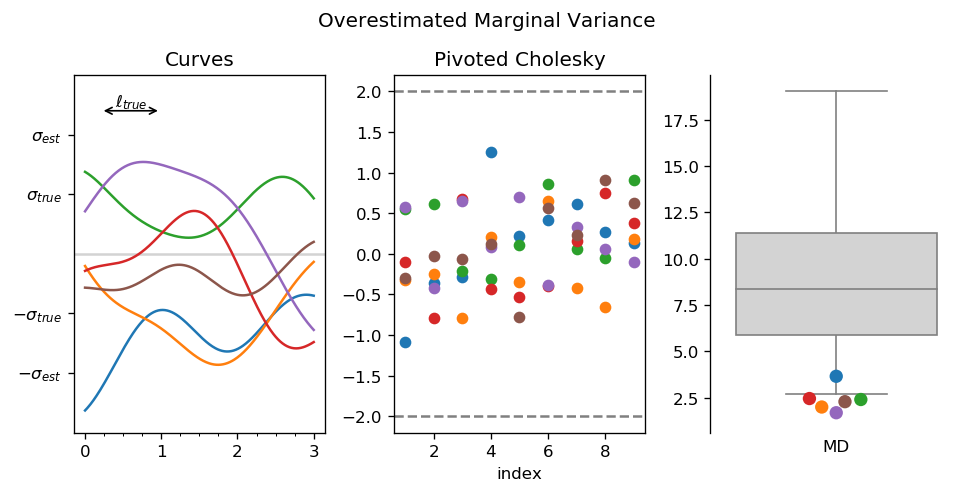

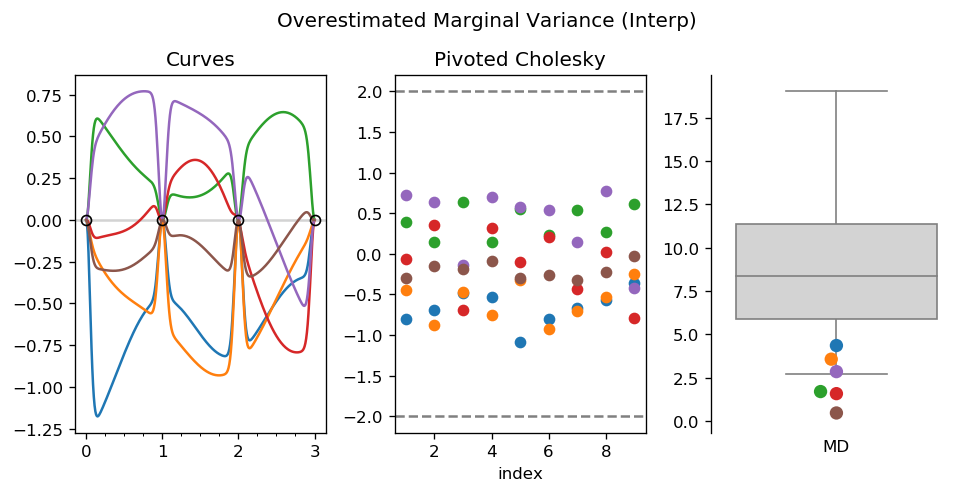

In [16]:
std_small = 0.5
kernel_small_sd = C(constant_value=std_small**2) * RBF(length_scale=ls) \
                  + WhiteKernel(noise)
gp = gm.ConjugateGaussianProcess(kernel_small_sd, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves)

fig, axes = plot_decomposition(data, kernel=kernel_PC, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=False, **gp_kwargs)
fig.suptitle('Overestimated Marginal Variance')
draw_std(std_small, 1, ax=axes[0])
draw_lengthscales(ls, ax=axes[0], std=0.8)
axes[0].set_ylim(-1.5, 1.5)


fig, axes = plot_decomposition(data, kernel=kernel, X=X_decomp, 
                               mask=mask_train, test_mask=mask_valid, 
                               interp=True,**gp_kwargs)
fig.suptitle('Overestimated Marginal Variance (Interp)');

### Other examples

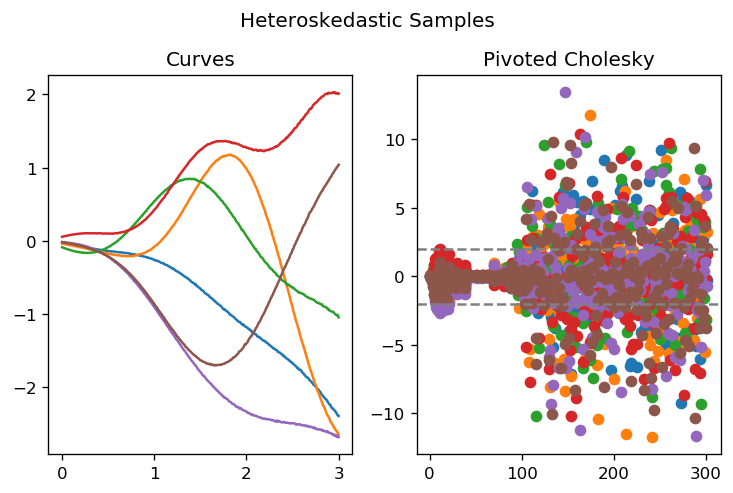

In [17]:
hetero_cov = ( np.linspace(0.1, 2, n_decomp) \
               * np.linspace(0.1, 2, n_decomp)[:, None] ) \
             * kernel_PC(X_decomp)

fig, axes = plot_decomposition_old(
    hetero_cov, est_mean=true_mean, est_cov=true_cov,
    X=X_decomp, n=n_simulated_curves)


fig.suptitle('Heteroskedastic Samples');

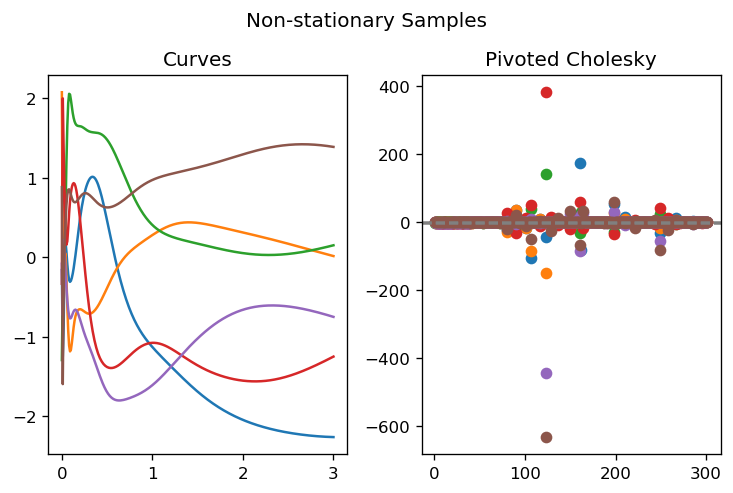

In [18]:
def rbf_var_ls(X, Xp=None, ls_func=None, **ls_kwargs):
    """An rbf kernel with a length scale function to introduce non-stationarity
    
    See MacKay's Intoduction to Gaussian Processes, Eq. (49).
    """
    if Xp is None:
        Xp = X
    diff = X[:, None, ...] - Xp[None, ...]
    dist = np.linalg.norm(diff, axis=-1)

    L = ls_func(X, **ls_kwargs)
    Lp = ls_func(Xp, **ls_kwargs)[:, None]
    ls_prefactor = np.sqrt(2 * L * Lp / (L**2 + Lp**2))
    return ls_prefactor * np.exp(- dist**2 / (L**2 + Lp**2))

# nonstationary_cov = rbf_var_ls(X_decomp, ls_func=lambda X: (X.ravel()+1e-5)**2)
nonstationary_cov = rbf_var_ls(X_decomp, ls_func=lambda X: np.abs(X.ravel()+1e-5))

fig, axes = plot_decomposition_old(
    nonstationary_cov, est_mean=true_mean, est_cov=true_cov,
    X=X_decomp, n=n_simulated_curves)

fig.suptitle('Non-stationary Samples');

It looks like length scale problems appear at large index, while marginal variance problems affect all indices equally. Non-stationarity appears at large index as well.

## Credible Interval Diagnostic

The credible interval diagnostic reference distribution must be generated by sampling. We've seen above that for the Mahalanobis distance, the reference is actually independent of the exact form of the covariance function. We know that's not true for the CI, since the length scale affects how wide the bands are.
But how robust is the distribution against scaling factors?
We would expect that a scalar wouldn't change the reference at all, but what about something like $Q(x)$, which shows up in the truncation distribution?

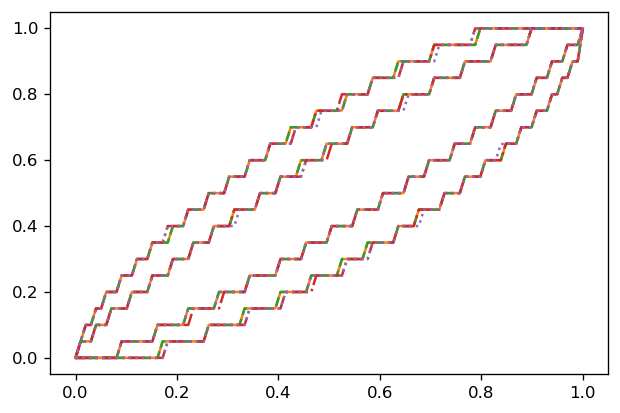

In [19]:
scales = [1, 200, np.logspace(1, 3, m), 
          np.linspace(0.1, 0.9, m)**2/(1 - np.linspace(0.1, 0.9, m)),
          ]
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]

fig, ax = plt.subplots()
for s, scale in enumerate(scales):
    scale = np.atleast_1d(scale)
    cov_n = scale * scale[:, None] * cov
    dgn_n = gm.Diagnostic(mean, cov_n)
    samps_n = dgn_n.samples(n_samples)
    dci_ref = dgn_n.credible_interval(samps_n, intervals)
    bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])

    greys = mpl.cm.get_cmap('Greys')
    for i, perc in enumerate(band_perc):
        ax.plot(intervals, bands[i, 0], c=f'C{s+1}', ls=['-', '--', '-.', ':'][s], zorder=s)
        ax.plot(intervals, bands[i, 1], c=f'C{s+1}', ls=['-', '--', '-.', ':'][s], zorder=s)

That's good news that even rather dramatic logarithmicly changing scale dependence doesn't change the reference by much at all (at least for the Gaussian RBF kernel).

One thing that has always bothered me a bit is the fact that the reference is jagged due to the finite number of points along a curve used to compute the reference distribution. What if we used a more finely sampled GP from the same process to generate the reference distribution?

200


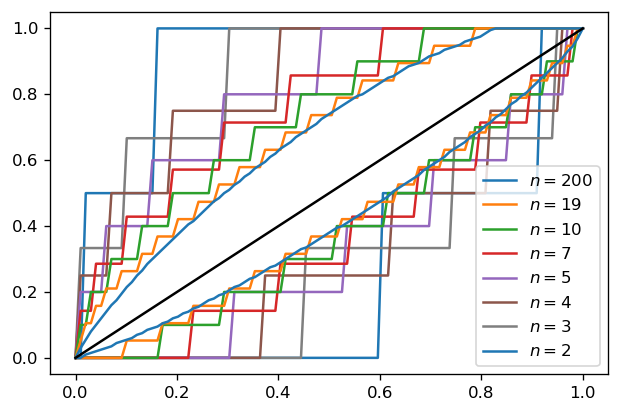

In [20]:
nn = 10*m
Xnew = np.linspace(0, 1, nn)[:, None]
# scales = [1, 200, np.logspace(1, 3, nn), #np.linspace(0.1, 0.9, n)**2/(1 - np.linspace(0.1, 0.9, n)),
#           np.exp(np.linspace(0, 5, n))]
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]

mean_new = np.zeros(Xnew.shape[0])
cov_new = kernel(Xnew)
print(nn)
fig, ax = plt.subplots()
length_prev = 0
for i, n_i in enumerate(range(1, nn, 10)):
    mean_n = mean_new[::n_i]
    
    length = len(mean_n)
    if length == length_prev:
        continue
    
    dgn_n = gm.Diagnostic(mean_n, cov_new[::n_i, ::n_i])
    samps_n = dgn_n.samples(n_samples)
    dci_ref = dgn_n.credible_interval(samps_n, intervals)
    bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])

    greys = mpl.cm.get_cmap('Greys')
#     for i, perc in enumerate([band_perc[1]]):
#         ax.plot(intervals, bands[i, 0], c=f'C{n_i//10 % 10}', zorder=-n_i)
#         ax.plot(intervals, bands[i, 1], c=f'C{n_i//10 % 10}', zorder=-n_i)
    ax.plot(intervals, bands[0, 0], c=f'C{i % 10}', zorder=-i, label=fr'$n={{{length}}}$')
    ax.plot(intervals, bands[1, 1], c=f'C{i % 10}', zorder=-i)
    length_prev = length
ax.plot([0, 1], [0,1], c='k')
ax.legend();

The top bands are the $2\sigma$ CI, whereas the lower bands are the $1\sigma$ CI.

It looks like the reference distribution from the finely sampled GP is more-or-less a lower bound to the credible intervals computed from the lower resolution GPs. So that means if we use the finely sampled GP (for prettiness sake) when the true GP is more sparse, then we might end up concluding failure when there actually is no failure to be found.


How about the CI diagnostic for different kernels? The easiest comparison would be the Matern for different values of $\nu$, with $\nu=\infty$ equivalent to the Gaussian kernel.

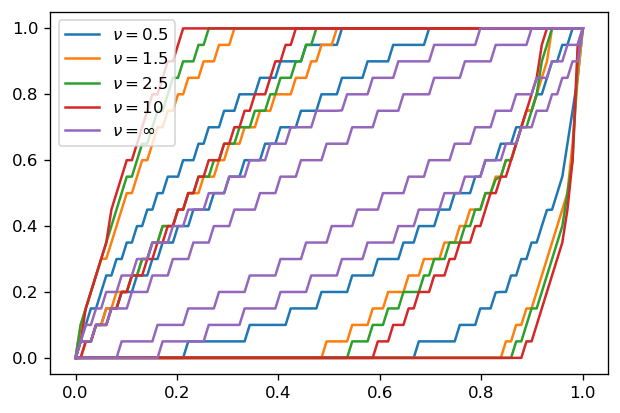

In [21]:
nus = [0.5, 1.5, 2.5, 10]
covs = [*[(Matern(ls, nu=nu) + WhiteKernel(1e-5))(X) for nu in nus],
        cov
       ]
names = [*nus, r'\infty']
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]

fig, ax = plt.subplots()
for s, cov_i in enumerate(covs):
    cov_n = cov_i
    dgn_n = gm.Diagnostic(mean, cov_n)
    samps_n = dgn_n.samples(n_samples)
    dci_ref = dgn_n.credible_interval(samps_n, intervals)
    bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])

    greys = mpl.cm.get_cmap('Greys')
    for i, perc in enumerate(band_perc):
        if i == 0:
            label = fr'$\nu = {names[s]}$'
        else:
            label = None
        ax.plot(intervals, bands[i, 0], c=f'C{s}', zorder=s, label=label)
        ax.plot(intervals, bands[i, 1], c=f'C{s}', zorder=s)
ax.legend();

Now back to the question from many months ago: do GP credible interval diagnostic bands correspond to a binomial distribution with an effective sample size?
And can that $N_{eff}$ be derived for each kernel?
In the notes, I proposed
\begin{align}
    N_{eff} = \frac{\Delta x}{\ell}
\end{align}
where $\Delta x$ is the difference between the minimum and maximum $x$ used in the GP regression.
As we can see below, this approximately holds so long as there are a sufficient number of points.

my Neff: 10.0
Vallejos et al. Neff: 5.58958856782408


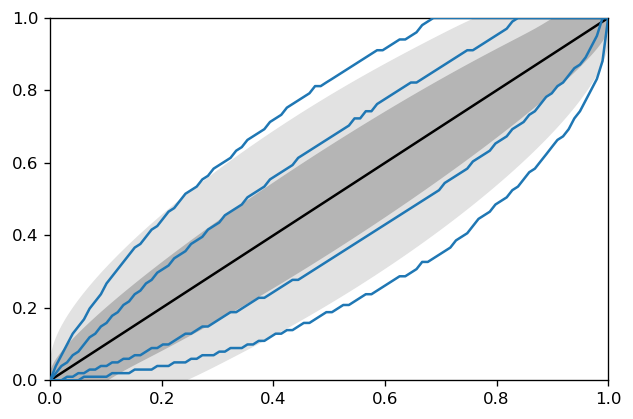

In [22]:
ax = plt.gca()

binom_68_u = []
binom_68_l = []
binom_95_u = []
binom_95_l = []


N = 101
Xvals = np.linspace(1, N, N)[:,None]
# diffX = Xvals[1,0] - Xvals[0,0]
diffX = np.max(Xvals) - np.min(Xvals)
ls_val = 10


binom_CI_domain = np.linspace(1e-5, 1, 100)
# Neff_vals = min(diffX / ls_val, N)
Neff_vals = diffX / ls_val * np.ones_like(binom_CI_domain)
# Neff_vals = N + (diffX / ls_val - N) * binom_CI_domain
print('my Neff:', diffX / ls_val)
# Neff_vals = diffX / ls_val / np.log(binom_CI_domain+1)

for i, p_decimal in enumerate(binom_CI_domain):
    Neff = Neff_vals[i]
    nn = p_decimal*Neff
    beta_args = {"a": nn+1, "b": Neff-nn+1, "loc": 0, "scale": 1}

    interval_68_perc = gm.hpd(stats.beta(**beta_args), alpha=0.68)

    binom_68_u.append(interval_68_perc[0])
    binom_68_l.append(interval_68_perc[1])
    
    interval_95_perc = gm.hpd(stats.beta(**beta_args), alpha=0.95)

    binom_95_u.append(interval_95_perc[0])
    binom_95_l.append(interval_95_perc[1])


ax.fill_betweenx(
        binom_CI_domain, binom_95_u, binom_95_l,
        facecolor=greys(0.2),
        color=greys(0.2),
        zorder=0)

ax.fill_betweenx(
        binom_CI_domain, binom_68_u, binom_68_l,
        facecolor=greys(0.4),
        color=greys(0.4),
        zorder=1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

binom_68_u2 = []
binom_68_l2 = []
binom_95_u2 = []
binom_95_l2 = []

# binom_CI_domain = np.linspace(1e-5, 1, 100)
# # Neff = min(diffX / ls_val, N)
# Neff_vals = diffX / ls_val / binom_CI_domain
# # print("Neff", Neff)
# for i, p_decimal in enumerate(binom_CI_domain):
#     Neff = Neff_vals[i]
#     norm = Neff
#     binom = stats.binom(n=Neff, p=p_decimal)
#     binom_68_l2.append(binom.ppf((1-0.68)/2) / norm)
#     binom_68_u2.append(binom.ppf((1+0.68)/2) / norm)
    
#     binom_95_l2.append(binom.ppf((1-0.95)/2) / norm)
#     binom_95_u2.append(binom.ppf((1+0.95)/2) / norm)


# ax.fill_between(
#         binom_CI_domain, binom_95_u2, binom_95_l2,
#         facecolor=greys(0.2),
#         color=greys(0.2),
#         zorder=0)

# ax.fill_between(
#         binom_CI_domain, binom_68_u2, binom_68_l2,
#         facecolor=greys(0.4),
#         color=greys(0.4),
#         zorder=1)


np.random.seed(1)
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]
mean_new = np.zeros(N)
ones_new = np.ones(N)
cov_new = (RBF(ls_val) + WhiteKernel(1e-7))(Xvals)
# cov_new = (Matern(ls_val) + WhiteKernel(1e-7))(Xvals)
# cov_new = (Matern(ls_val, nu=0.5) + WhiteKernel(1e-7))(Xvals)
dgn_n = gm.Diagnostic(mean_new, cov_new)
samps_n = dgn_n.samples(n_samples)
dci_ref = dgn_n.credible_interval(samps_n, intervals)
bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                      for bi in band_perc])

print('Vallejos et al. Neff:', ones_new @ np.linalg.solve(cov_new, ones_new))

greys = mpl.cm.get_cmap('Greys')
for i, perc in enumerate(band_perc):
    if i == 0:
        label = fr'$\nu = {names[s]}$'
    else:
        label = None
    ax.plot(intervals, bands[i, 0], c=f'C{0}', zorder=s, label=label)
    ax.plot(intervals, bands[i, 1], c=f'C{0}', zorder=s)
# ax.axvline(0.5, 0, 1, c='grey')
ax.plot([0, 1], [0,1], c='k');